In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import seaborn as sns
from itertools import cycle
import matplotlib.style as style
style.use('seaborn')

colors = cycle(["C{}".format(i) for i in range(10)])

In [4]:
import functions as f

stations = pd.read_csv("stations.csv")
lats = list(stations.get('latitude'))
longs = list(stations.get('longitude'))

names = []
towns = []
points = []
for index, row in stations.iterrows():
    names.append( row['name'] )
    towns.append( row["town"] )
    lat = lats[index]
    long = longs[index]
    points.append( (lat, long) )

In [28]:
import functions as f
import datetime

trips = pd.read_csv("trips2.csv")

trips["start_time"] = pd.to_datetime(trips["start_time"])
trips["duration"] = pd.to_timedelta(trips["duration"])
deltaF = datetime.timedelta(minutes=1) # filter out trips which take less than 1 min
deltaC = datetime.timedelta(hours=24) # filter out trips which take longer than a day
trips = trips.loc[trips['duration'] > deltaF]
trips = trips.loc[trips['duration'] < deltaC]

timeRange = trips["start_time"].to_list()

display(trips)

,Unnamed: 0,id,start_station,start_city,end_station,end_city,start_time,duration
0,0,route_10_2020@a2a17c30-d848-4ded-94f0-bd8ae05a...,Main Street/Bridge Street,Northampton,Florence Center,Northampton,2020-10-06 12:37:36+00:00,0 days 00:17:25
1,1,route_10_2020@5b2f37e6-e06a-43ae-949e-b2ffd2de...,Village Hill/State Hospital,Northampton,Village Hill/State Hospital,Northampton,2020-10-06 12:42:02+00:00,0 days 00:41:35
2,2,route_10_2020@c74f25cd-e0c6-4fe7-9a2f-7e31324f...,Florence Center,Northampton,Florence Center,Northampton,2020-10-06 12:44:47+00:00,0 days 00:49:40
3,3,route_10_2020@ff5d4317-b149-42a4-bc5e-9bc101da...,YMCA/Childs Park,Northampton,John M Greene Hall/Smith College,Northampton,2020-10-06 12:49:30+00:00,0 days 00:06:00
4,4,route_10_2020@2b54f8e3-ed53-48ab-b065-43d59144...,Jackson Street,Northampton,State St/Mass Central Rail Trail,Northampton,2020-10-06 12:58:39+00:00,0 days 00:24:25
...,...,...,...,...,...,...,...,...
166283,166283,route_06_2022@9f9c149d-b8af-4d43-8882-5b6d7cb9...,Amherst Town Hall,Amherst,University Drive,Amherst,2022-06-07 02:20:55+00:00,0 days 00:07:00
166284,166284,route_06_2022@aa343271-8410-440e-9329-f8fa76ad...,University Drive,Amherst,University Drive,Amherst,2022-06-07 02:29:10+00:00,0 days 00:10:00
166285,166285,route_06_2022@42643acc-7592-4aa7-aff1-b667a2e3...,Mackenzie Field,Holyoke,Holyoke Medical Center Station,Holyoke,2022-06-07 02:34:58+00:00,0 days 00:07:45
166286,166286,route_06_2022@39cbaf9d-d9eb-460c-8f4d-f16ea151...,El Corazon,Holyoke,South Holyoke,Holyoke,2022-06-07 02:47:24+00:00,0 days 00:28:00


In [29]:
from datetime import date

def rem_time(d):
    s = date(d.year,d.month, d.day)
    return s

def plot_daily_num_trips(trips, townname="all towns", color='k'):
    trips.sort_values(by='start_time')
    dateTrip = {}

    for index, row in trips.iterrows():
        day = rem_time(row['start_time'])
        if day not in dateTrip.keys():
            dateTrip[day] = 1
        else:
            dateTrip[day] += 1

    dates = list(dateTrip.keys())
    numTrips = list(dateTrip.values())
    plt.figure(figsize=(8,3), dpi=150)
    plt.plot(dates, numTrips, color=color)
    plt.title("Trips started in {} over time".format(townname))
    plt.ylabel('number of trips'.format(townname))
    plt.xlabel("Date")
    plt.xlim(timeRange[0], timeRange[-1])
    plt.tight_layout()
    path = "./plots/num_trips.png"
    if townname != "all towns":
        path = "./plots/by_city/{}_trips.png".format(townname)
    plt.savefig(path, facecolor='w')

def plot_daily_num_trips_bar(trips, stationname="all stations", color='k'):
    trips.sort_values(by='start_time')
    dateTrip = {}

    for index, row in trips.iterrows():
        day = rem_time(row['start_time'])
        if day not in dateTrip.keys():
            dateTrip[day] = 1
        else:
            dateTrip[day] += 1

    dates = list(dateTrip.keys())
    numTrips = list(dateTrip.values())
    plt.figure(figsize=(8,3), dpi=150)
    plt.bar(dates, numTrips, color=color)
    plt.title("Trips started at {} station over time".format(stationname))
    plt.ylabel('number of trips'.format(stationname))
    plt.xlabel("Date")
    plt.xlim(timeRange[0], timeRange[-1])
    plt.tight_layout()
    path = "./plots/num_trips_bar.png"
    if stationname != "all stations":
        path = "./plots/by_station/{} trips.png".format(stationname)
    plt.savefig(path, facecolor='w')

def plot_dist_durations(trips, townname="all towns"):
    durations = [x.total_seconds() for x in trips['duration']]
    print(min(durations))
    print(max(durations))
    plt.figure(figsize=(7,3), dpi=150)
    stat = "proportion"  # or proportion
    sns.histplot(durations, stat=stat, cumulative=True, alpha=.4)
    sns.ecdfplot(durations, stat=stat)
    plt.xlim(0, 20000)
    plt.title("Cumulative Distribution of Trip Durations in {}".format(townname))
    plt.ylabel("Probability")
    plt.xlabel("Trip Duration in Seconds")
    path = "./plots/durations.png"
    if townname != "all towns":
        path = "./plots/by_city/{}_durations.png".format(townname)
    plt.savefig(path, facecolor='w')

# plot_dist_durations(trips)

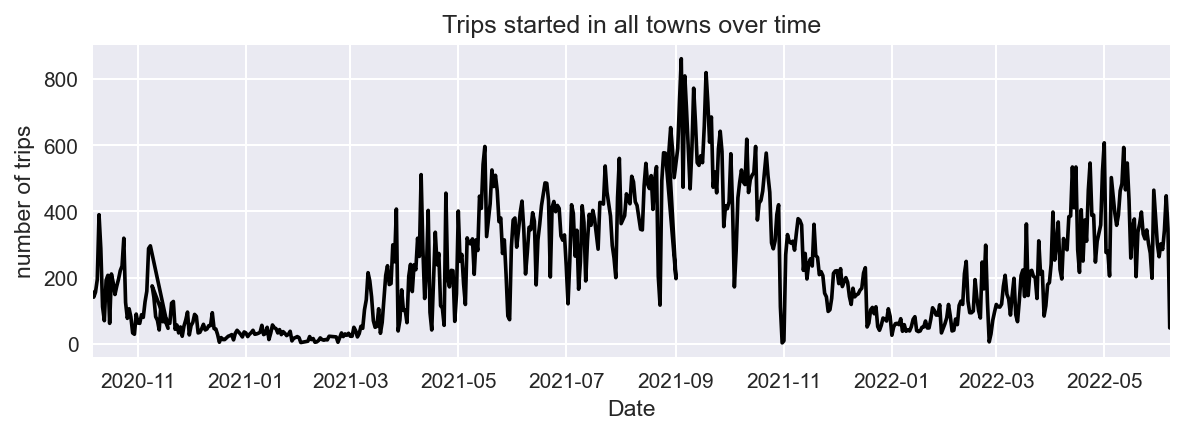

In [30]:
plot_daily_num_trips(trips)

Daily Trips starting in West Springfield
Daily Trips starting in South Hadley
Daily Trips starting in Easthampton
Daily Trips starting in Holyoke
Daily Trips starting in Northampton
Daily Trips starting in Chicopee
Daily Trips starting in Springfield
Daily Trips starting in Amherst


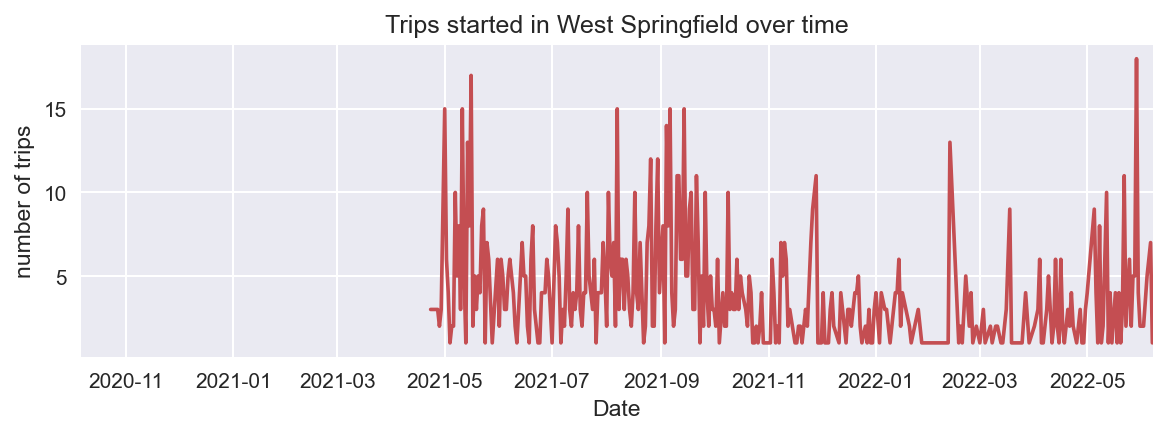

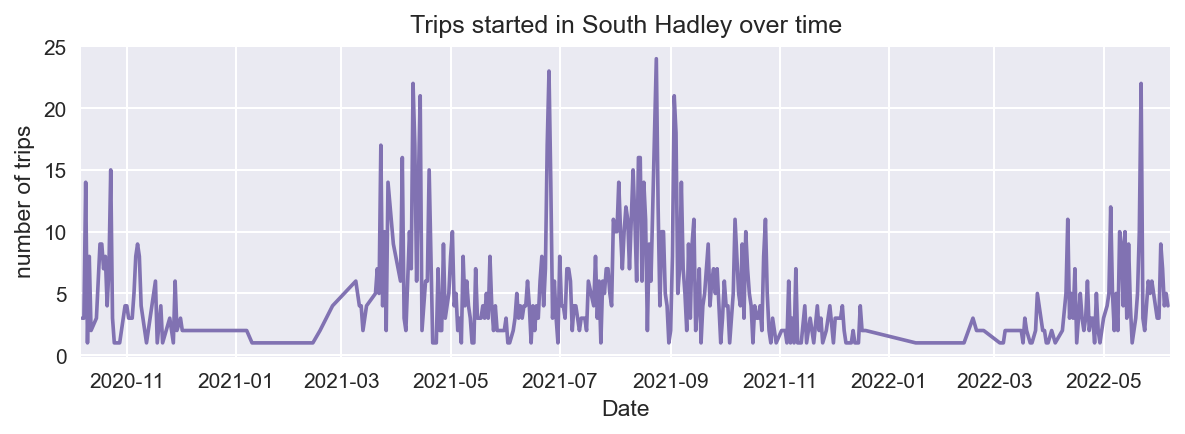

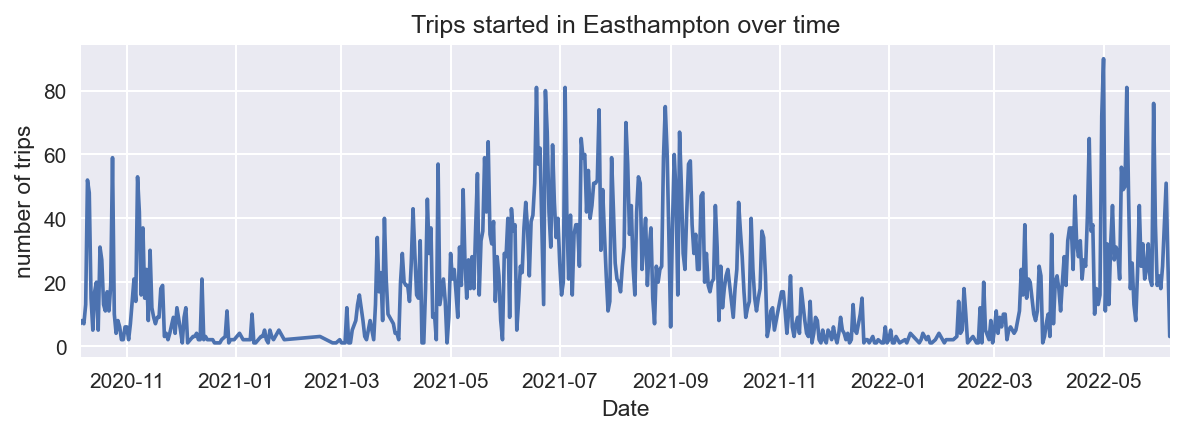

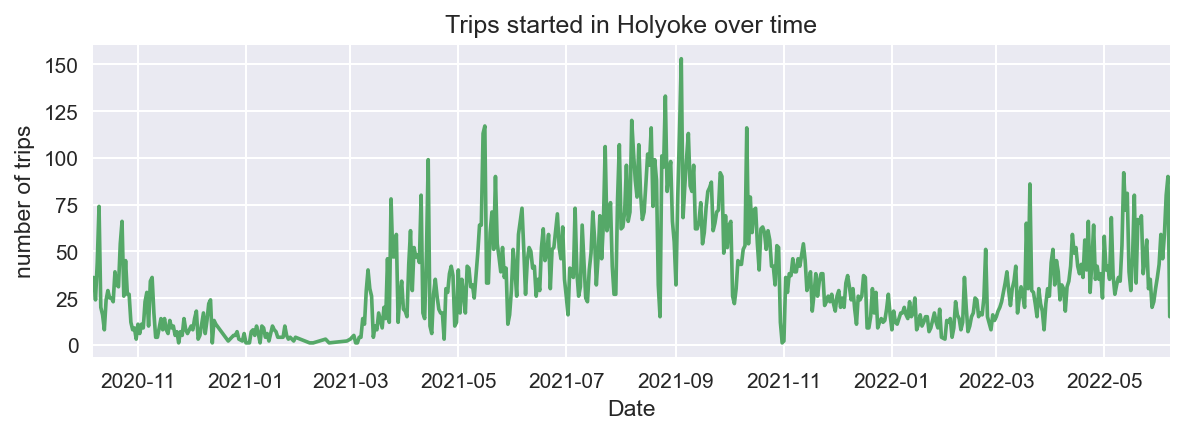

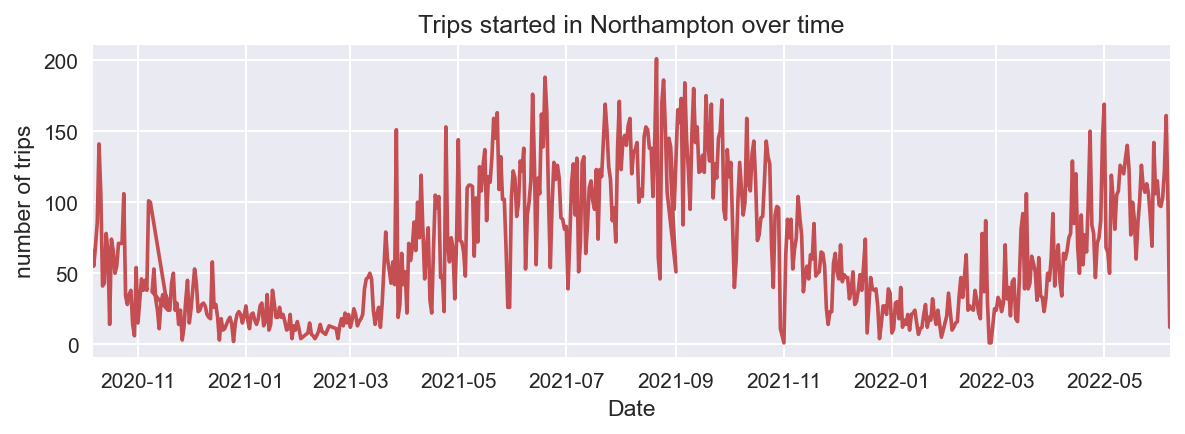

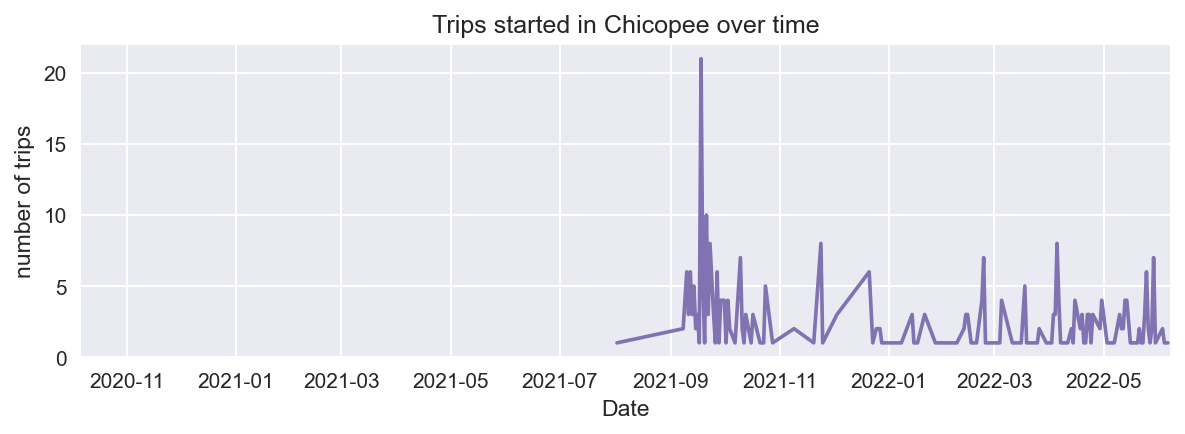

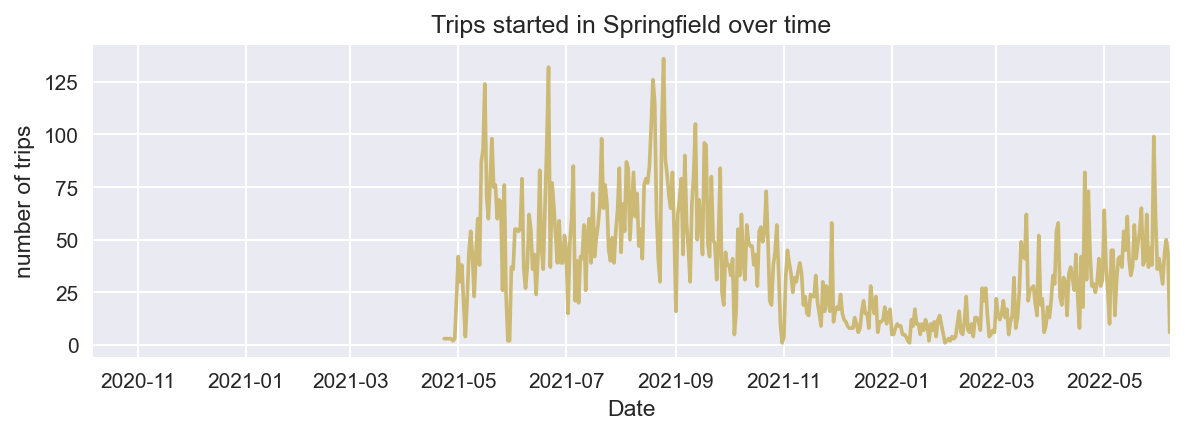

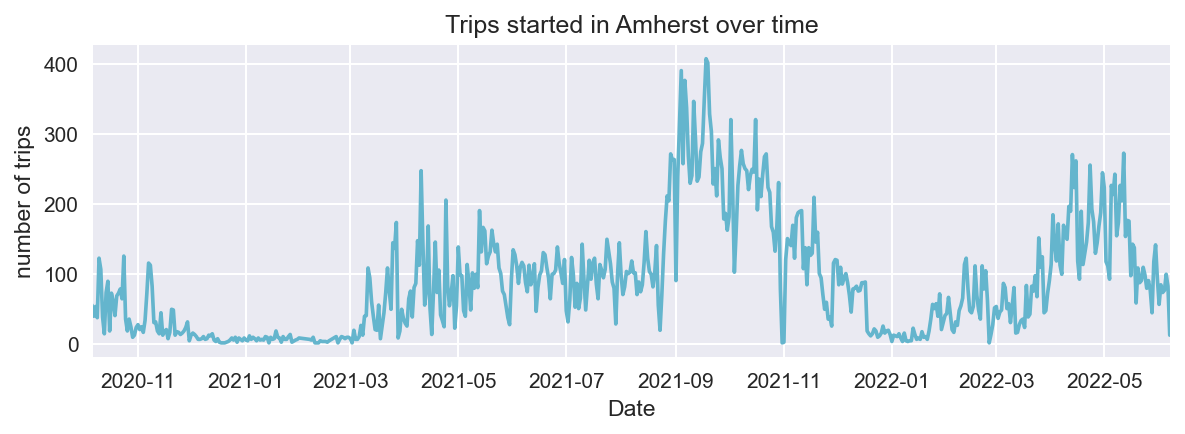

In [31]:
towns = set(towns)
for town in towns:
    towntrips = trips.loc[trips['start_city'].str.contains(town)]
    print("Daily Trips starting in {}".format(town))
    plot_daily_num_trips(towntrips, townname=town, color=next(colors))

In [32]:
difftrips = trips.loc[trips['start_city'] != trips['end_city']]
display(difftrips)

,Unnamed: 0,id,start_station,start_city,end_station,end_city,start_time,duration
6,6,route_10_2020@8aca36ae-cd76-4ff4-99ae-439478a8...,The Pedlar Station/Crosier Field,Holyoke,Northampton Train Station,Northampton,2020-10-06 13:11:02+00:00,0 days 00:46:10
12,12,route_10_2020@6f120d89-d155-4fe1-aed5-1b109e26...,Northampton Train Station,Northampton,Rail Trail @ Union Street,Easthampton,2020-10-06 14:52:04+00:00,0 days 00:21:00
13,13,route_10_2020@703757ec-c807-4196-9eb8-059b7474...,Northampton Train Station,Northampton,Rail Trail @ Union Street,Easthampton,2020-10-06 15:37:00+00:00,0 days 00:26:05
15,15,route_10_2020@62a6ecf8-0d2b-4ff9-8ec8-64fddd27...,Rail Trail @ Union Street,Easthampton,Northampton Train Station,Northampton,2020-10-06 15:41:19+00:00,0 days 00:19:30
57,57,route_10_2020@07c90dcf-5964-40bd-8c5a-1f9d6549...,Main Street/Bridge Street,Northampton,University Drive,Amherst,2020-10-06 18:45:19+00:00,0 days 00:39:50
...,...,...,...,...,...,...,...,...
166180,166180,route_06_2022@5fb049b0-c1aa-4eed-9b25-80ba1ac9...,Rail Trail @ Millside Park,Easthampton,Mackenzie Field,Holyoke,2022-06-06 22:51:23+00:00,0 days 00:45:50
166182,166182,route_06_2022@9d709cf6-d301-43f2-b5a8-4fe3024e...,Rail Trail @ Millside Park,Easthampton,Mackenzie Field,Holyoke,2022-06-06 22:51:53+00:00,0 days 00:45:20
166206,166206,route_06_2022@79c875ca-debd-4aa9-ad38-9d4d7542...,West Springfield Memorial Avenue,West Springfield,Baystate Health/Main Street,Springfield,2022-06-06 23:29:46+00:00,0 days 00:23:45
166232,166232,route_06_2022@58db5eb2-02b7-4006-b34b-aa187306...,Live Well Springfield Station,Springfield,Chicopee City Hall,Chicopee,2022-06-07 00:10:30+00:00,0 days 00:23:55


In [33]:
11315.0/142340.0

0.07949276380497401

Daily Trips starting in one city, ending in another


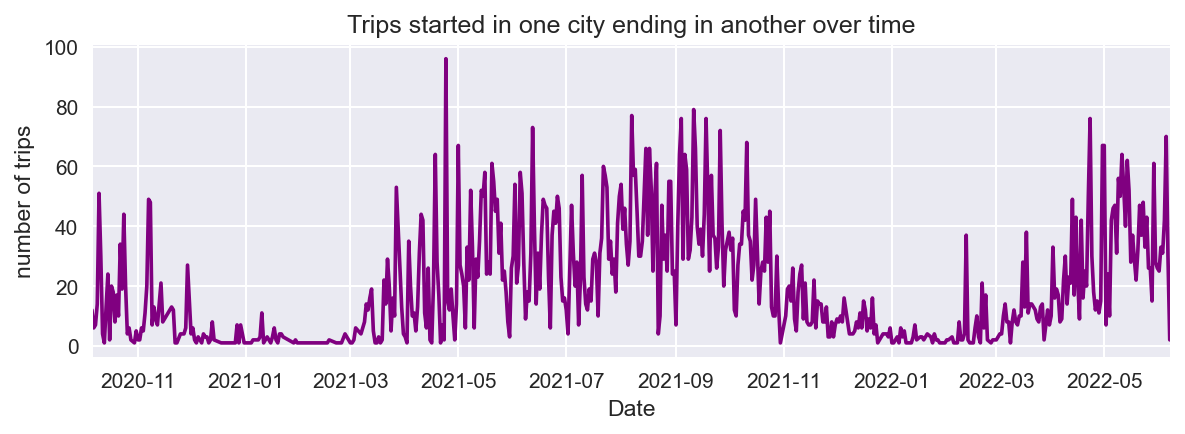

In [36]:
print("Daily Trips starting in one city, ending in another")
plot_daily_num_trips(difftrips, townname="one city ending in another", color='purple')

Daily Trips starting at North Pleasant Street
Daily Trips starting at UMass Sylvan Residential Area
Daily Trips starting at UMass Knowlton
Daily Trips starting at UMass ILC
Daily Trips starting at UMass Central Residential Area
Daily Trips starting at UMass Haigis Mall
Daily Trips starting at UMass Southwest
Daily Trips starting at Kendrick Park
Daily Trips starting at Amherst Town Hall
Daily Trips starting at South East Street
Daily Trips starting at University Drive
Daily Trips starting at East Hadley Road
Daily Trips starting at Mount Holyoke College Station
Daily Trips starting at Woodlawn Plaza
Daily Trips starting at Eink Station
Daily Trips starting at Rivers Park
Daily Trips starting at Chicopee Falls
Daily Trips starting at Chicopee City Hall
Daily Trips starting at Baystate Health/Main Street


FileNotFoundError: [Errno 2] No such file or directory: './plots/by_station/Baystate Health/Main Street trips.png'

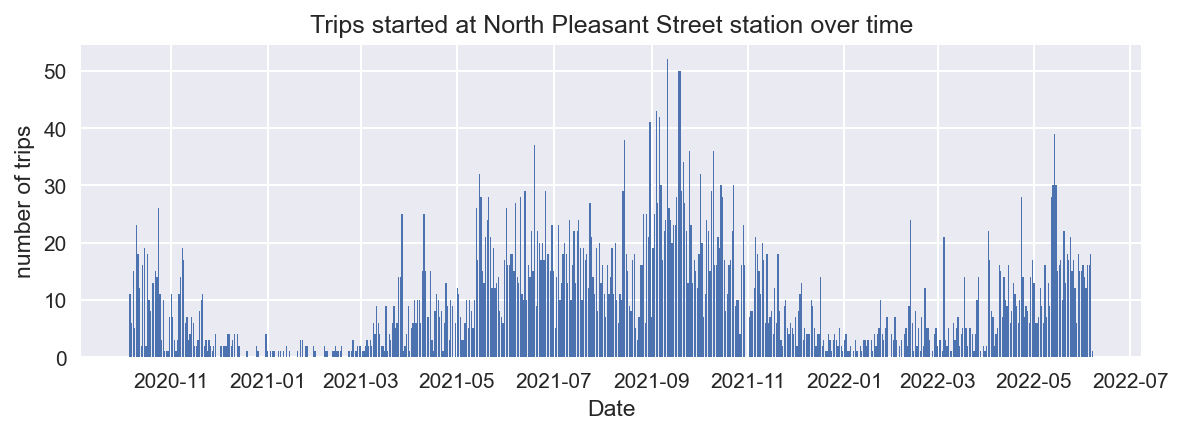

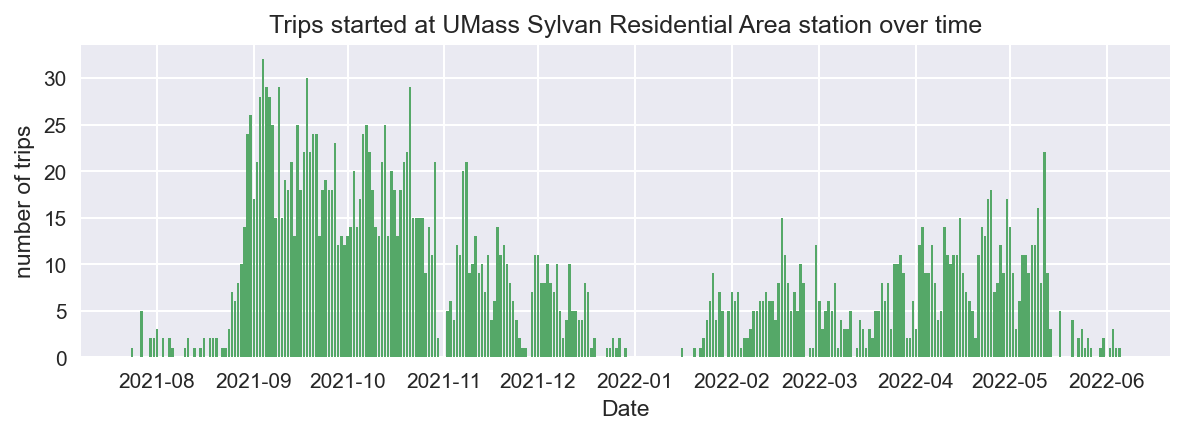

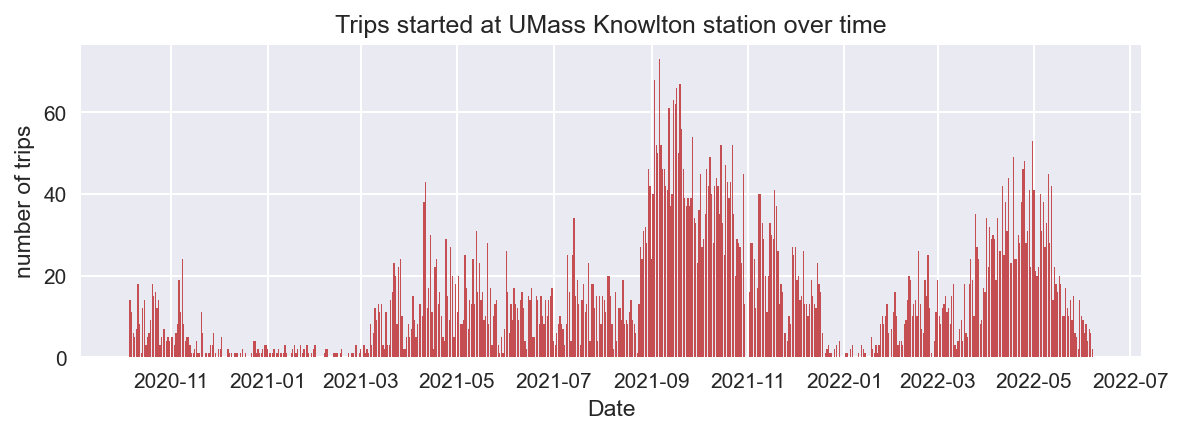

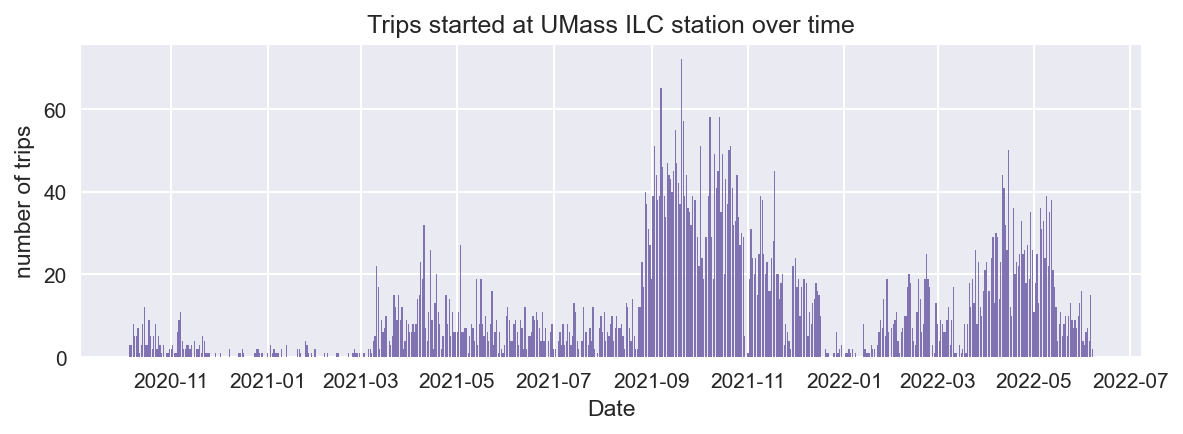

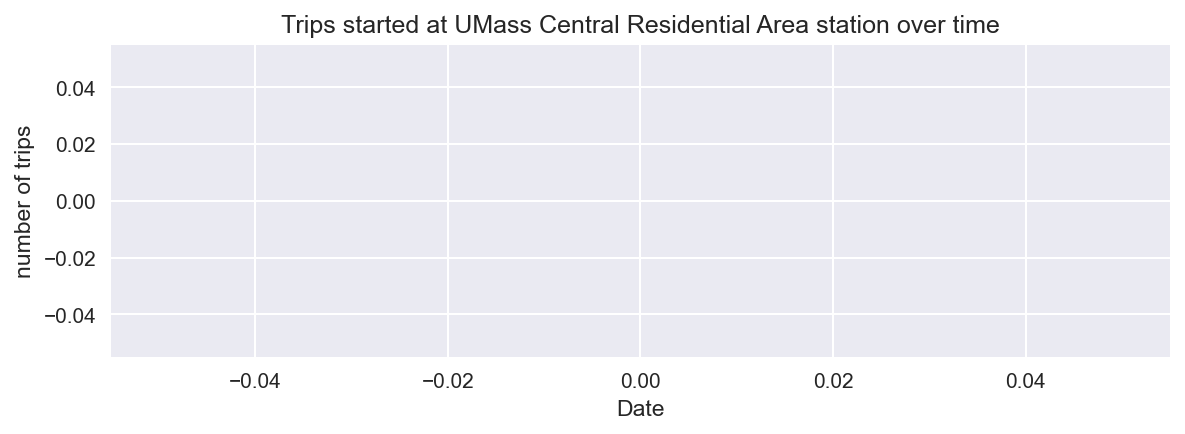

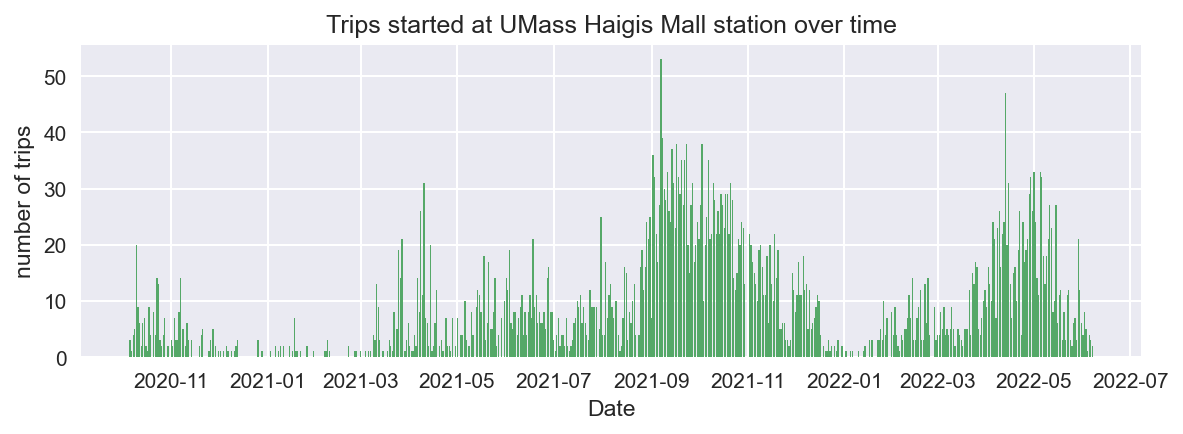

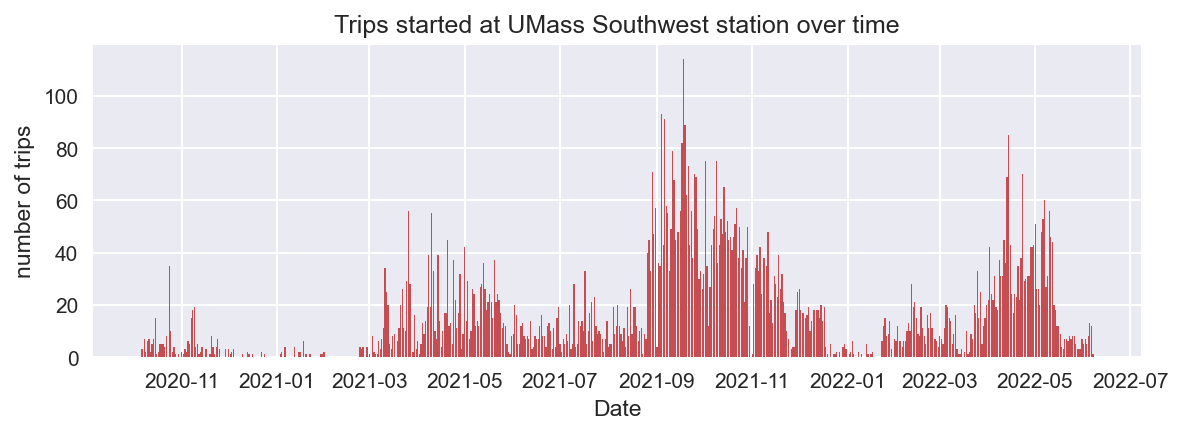

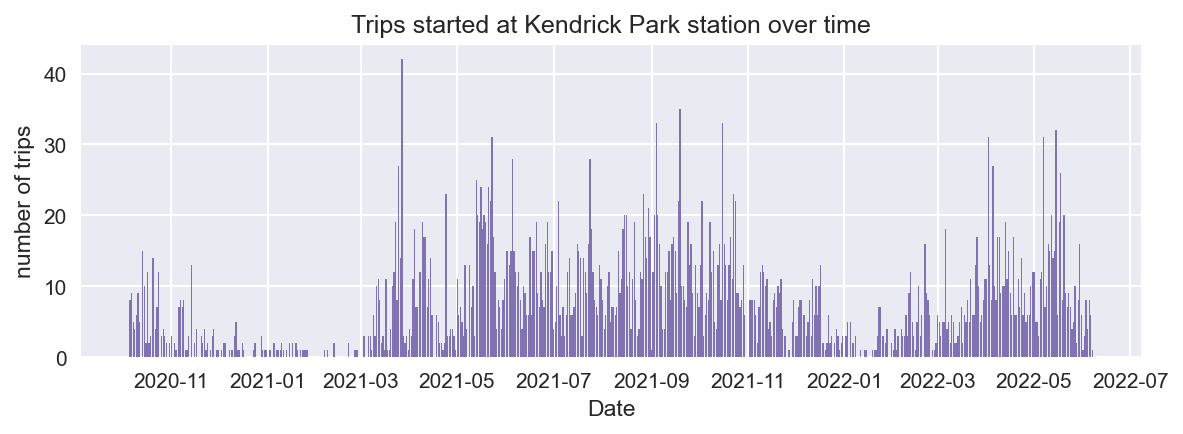

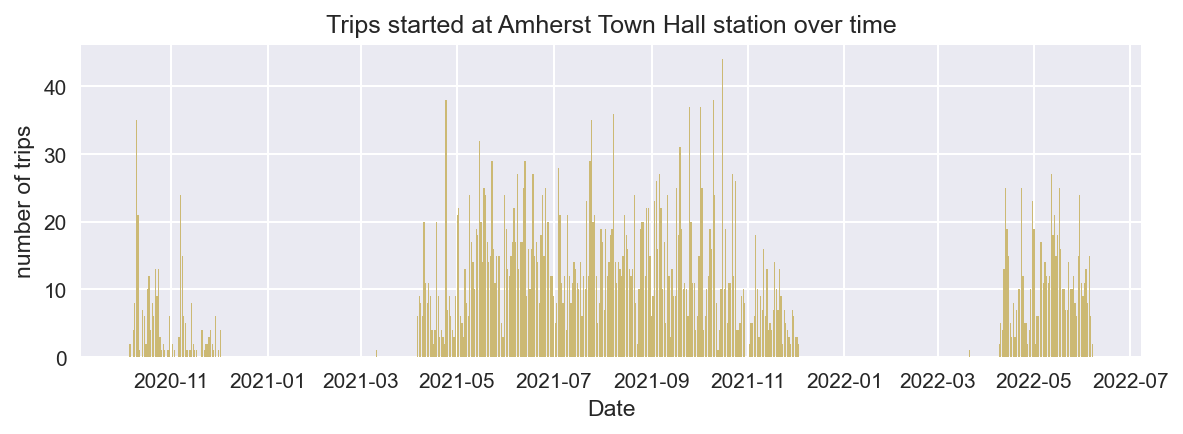

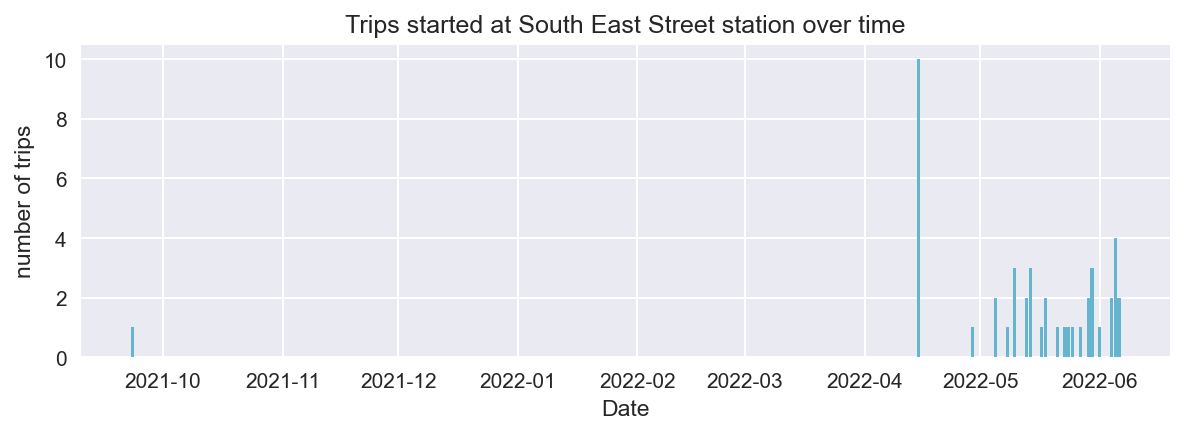

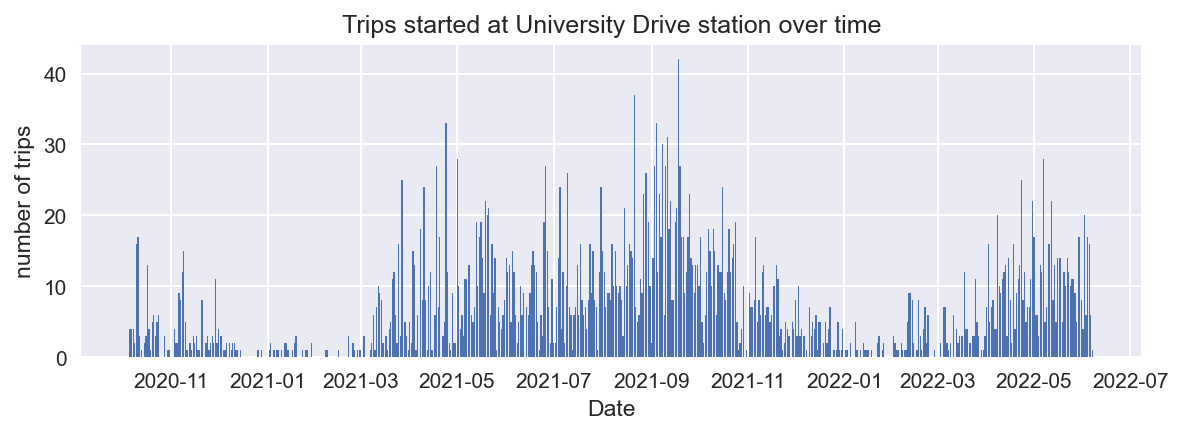

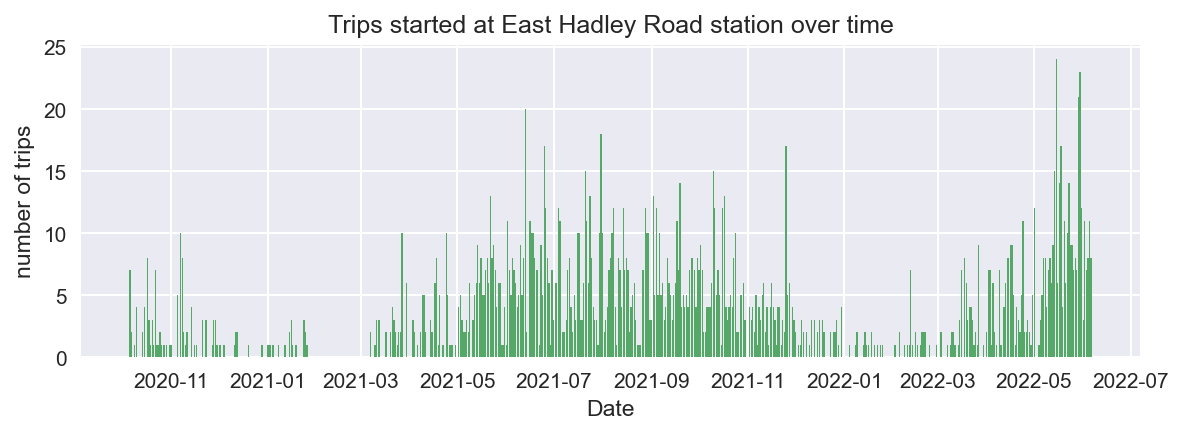

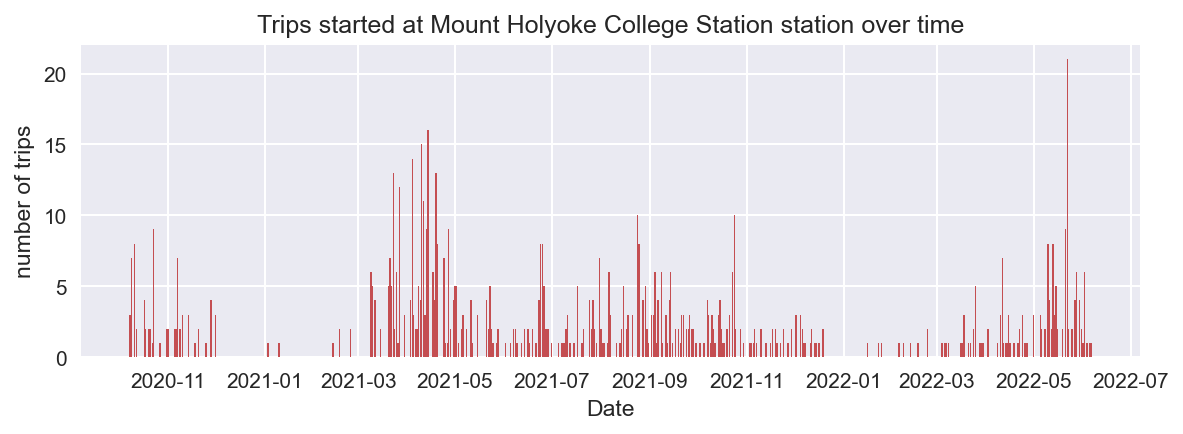

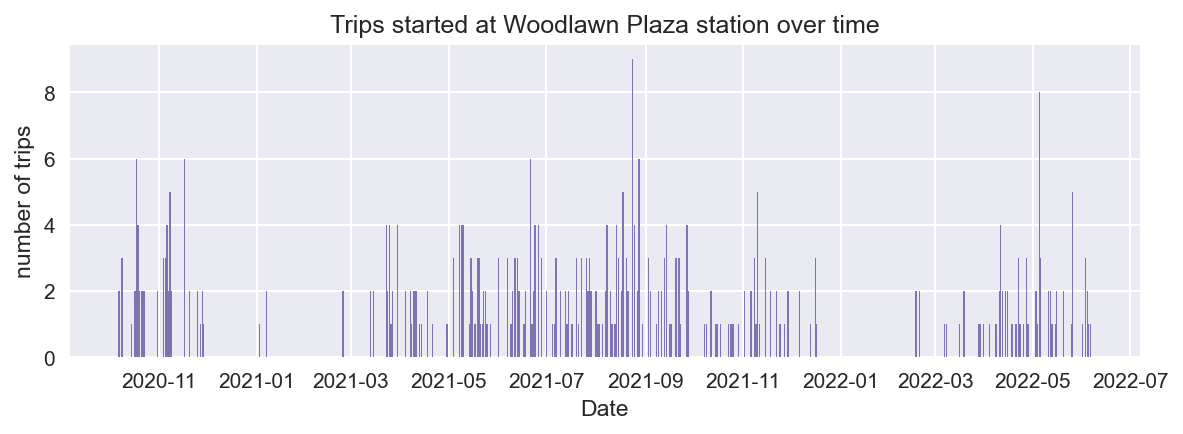

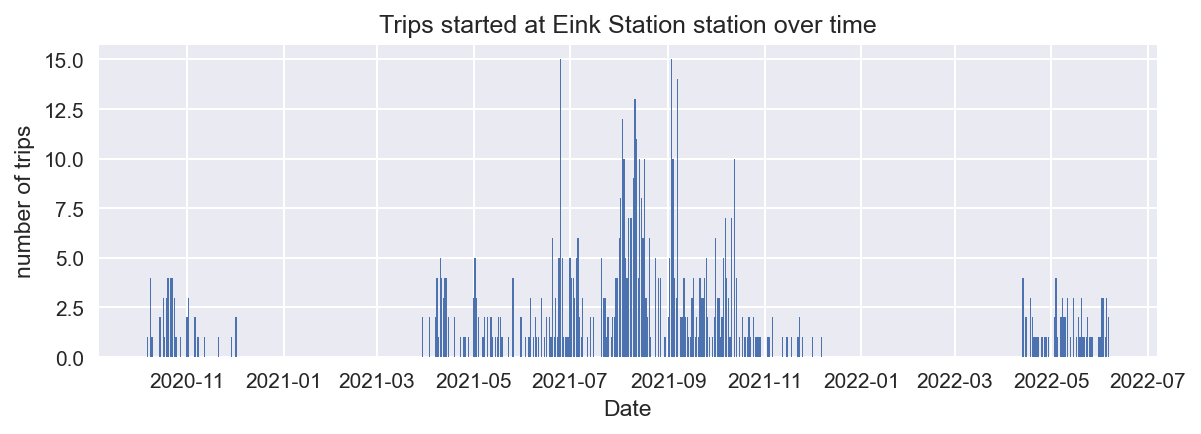

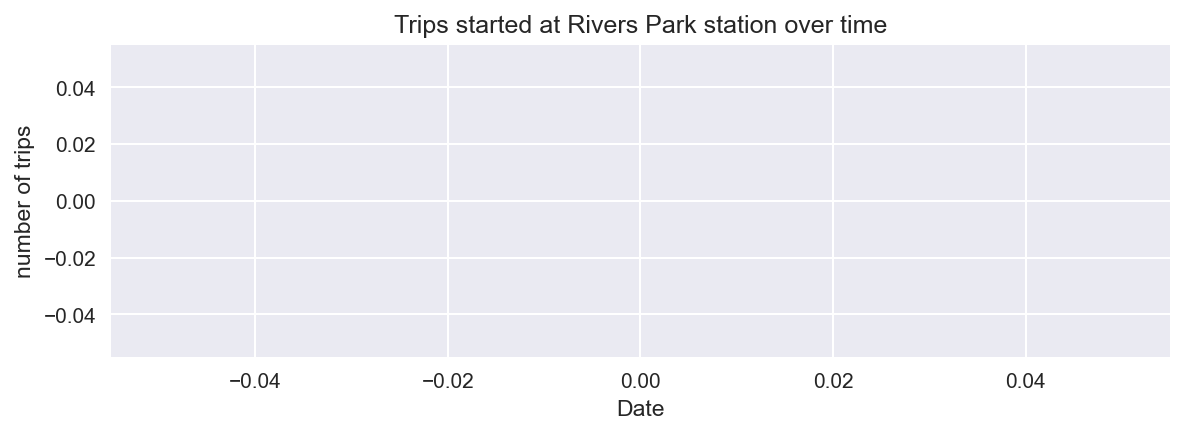

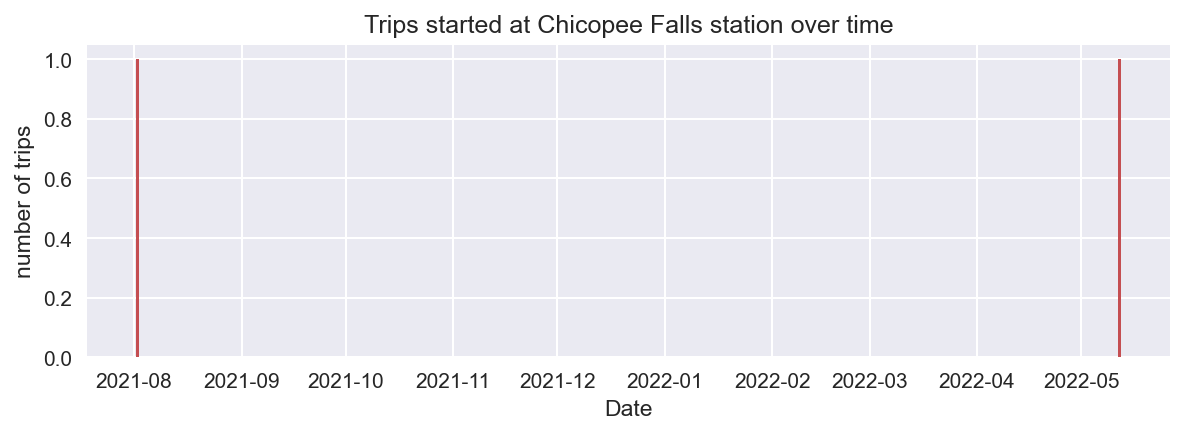

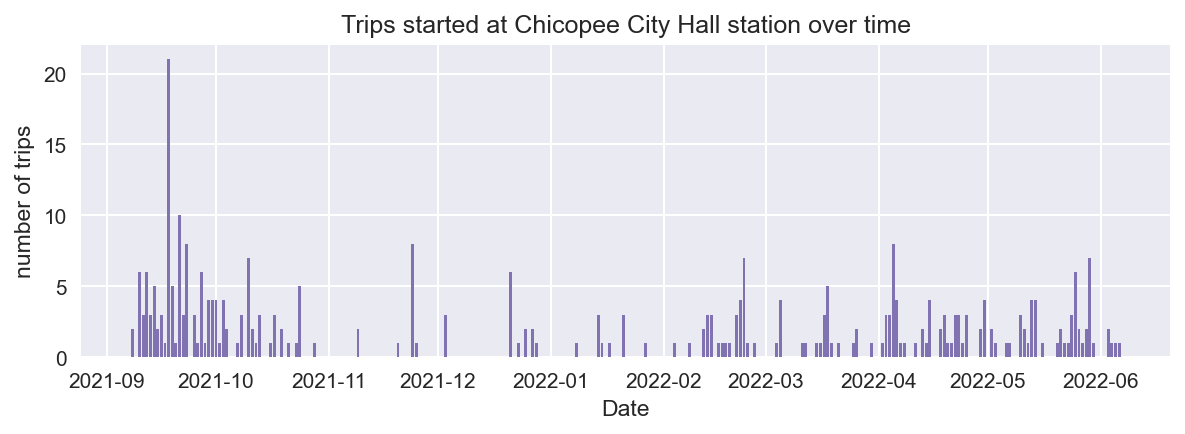

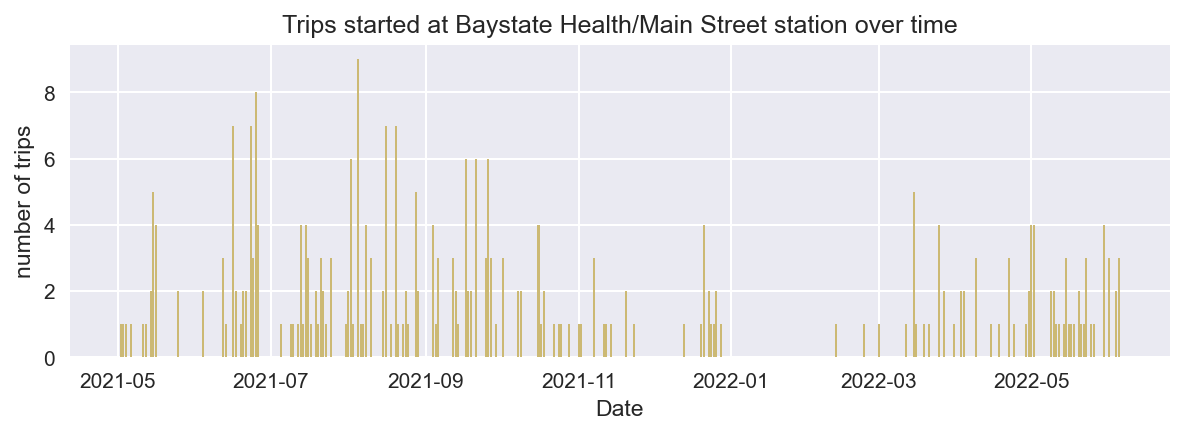

In [39]:
for stationname in names:
    stattrips = trips.loc[trips['start_station'].str.contains(stationname)]
    print("Daily Trips starting at {}".format(stationname))
    plot_daily_num_trips_bar(stattrips, stationname=stationname, color=next(colors))
    
# umtrips = trips.loc[trips['start_station'].str.contains("UMass Haigis Mall")]
# chtrips = trips.loc[trips['start_station'].str.contains("Chicopee City Hall")]
# sptrips = trips.loc[trips['start_station'].str.contains("Springfield Armory")]
# ehtrips = trips.loc[trips['start_station'].str.contains("Easthampton City")]

# plot_daily_num_trips_bar(umtrips, stationname="UMass Haigis Mall", color='magenta')
# plot_daily_num_trips_bar(sptrips, stationname="Springfield Armory", color='blue')
# plot_daily_num_trips_bar(ehtrips, stationname="Easthampton City Hall", color='red')

In [8]:
def plot_dist_durations(trips, townname="all towns"):
    startAndEnd = list(zip(trips['start_station'], trips['end_station']))
    plt.figure(figsize=(7,3), dpi=150)
    stat = "count"  # or proportion
    plt.hist(startAndEnd)
    #sns.histplot(startAndEnd, stat=stat, cumulative=False, alpha=.4)
    # sns.ecdfplot(startAndEnd, stat=stat)
    # plt.xlim(0, 20000)
    # plt.title("Cumulative Distribution of Trip Durations in {}".format(townname))
    # plt.ylabel("Probability")
    # plt.xlabel("Trip Duration in Seconds")
    plt.show()

plot_dist_durations(trips)


KeyboardInterrupt: 